In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
pd.set_option('mode.chained_assignment', None)

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [2]:
covid_data = pd.read_csv('owid-covid-data.csv')

In [3]:
#useful data constants
RUSSIA_COUNTRY_LABEL = 'Russia'
SIZE_OF_COUNTS_IN_TRAIN = 50
LOCATION = 'location'
DATE = 'date'
TOTAL_CASES = 'total_cases'
NEW_CASES = 'new_cases'
DAY_COUNTER = 'day_counter'
COLUMNS = [LOCATION, DATE, TOTAL_CASES, NEW_CASES]
DATE_FORMAT = '%Y-%m-%d'

#useful date constants
RUSSIA_START_DATE = datetime(2020, 3, 3)
FIRST_MAY = datetime(2020, 5, 1)
FIRST_MAY_DAYS = (FIRST_MAY - RUSSIA_START_DATE).days
FIRST_JUNE = datetime(2020, 6, 1)
FIRST_JUNE_DAYS = (FIRST_JUNE - RUSSIA_START_DATE).days
FIRST_SEPTEMBER = datetime(2020, 9, 1)
FIRST_SEPTEMBER_DAYS = (FIRST_SEPTEMBER - RUSSIA_START_DATE).days

#useful plotting constants
FIGURE_SIZE = (12, 8)
X_LABEL = 'Date'
Y_LABEL = 'Number of cases'

NUMBER_OF_SAMPLES = 1000

In [4]:
#data preparation function
def get_data(data = covid_data, country_label = RUSSIA_COUNTRY_LABEL, start_date = RUSSIA_START_DATE):
    filtered_data = data.filter(COLUMNS)
    filtered_data[DATE] = pd.to_datetime(filtered_data[DATE], format=DATE_FORMAT)
    country_data = filtered_data.loc[filtered_data[LOCATION] == country_label]
    #add column with a date counter
    country_data.loc[:, DAY_COUNTER] = (country_data[DATE] - start_date).dt.days
    country_data = country_data.loc[country_data[DAY_COUNTER] >= 0]
    country_data.loc[country_data[NEW_CASES] == 0.0, NEW_CASES] = 1.
    return country_data, country_data.copy().head(SIZE_OF_COUNTS_IN_TRAIN)

2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

Text(0, 0.5, 'Number of cases')

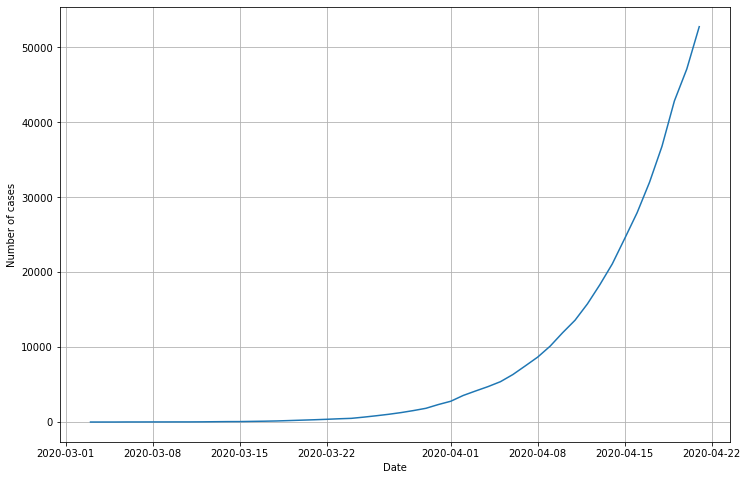

In [5]:
#total cases
full_data, train_data = get_data()

plt.figure(figsize=FIGURE_SIZE) 
plt.grid()
plt.plot(train_data[DATE], train_data[TOTAL_CASES])
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)

Text(0, 0.5, 'Number of cases')

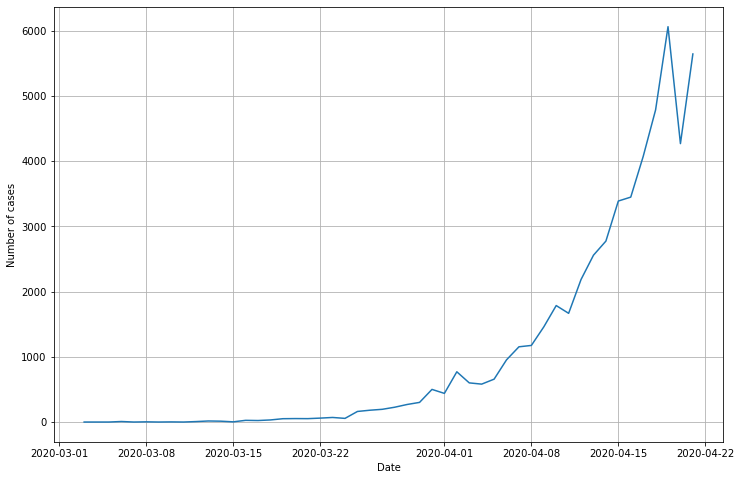

In [6]:
#new cases
plt.figure(figsize=FIGURE_SIZE) 
plt.grid()
plt.plot(train_data[DATE], train_data[NEW_CASES])
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)

**a.** Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [7]:
estimator = LinearRegression()
estimator.fit(train_data[DAY_COUNTER].values.reshape(-1, 1), np.log(train_data[TOTAL_CASES]))

LinearRegression()

In [8]:
prediction = estimator.predict(train_data[DAY_COUNTER].values.reshape(-1, 1))

**b.** Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).


In [9]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [10]:
sigma_n = 100 * np.array([[1, 0], [0, 1]])
mu_n = np.array([0, 0])
x = train_data[DAY_COUNTER].values
y = np.log(train_data[TOTAL_CASES]).values
sigma_noise = np.std(np.log(train_data[TOTAL_CASES]) - prediction)

for i in range(0, len(train_data[TOTAL_CASES])):
    mu_n, sigma_n = bayesian_update(mu_n, sigma_n, x[i], y[i], sigma_noise)

print(f'sigma:\n {sigma_n}')
print(f'mu: {mu_n}')

sigma:
 [[ 9.45888140e-03 -2.86632761e-04]
 [-2.86632761e-04  1.16995814e-05]]
mu: [1.8205655  0.19829611]


**c.** Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


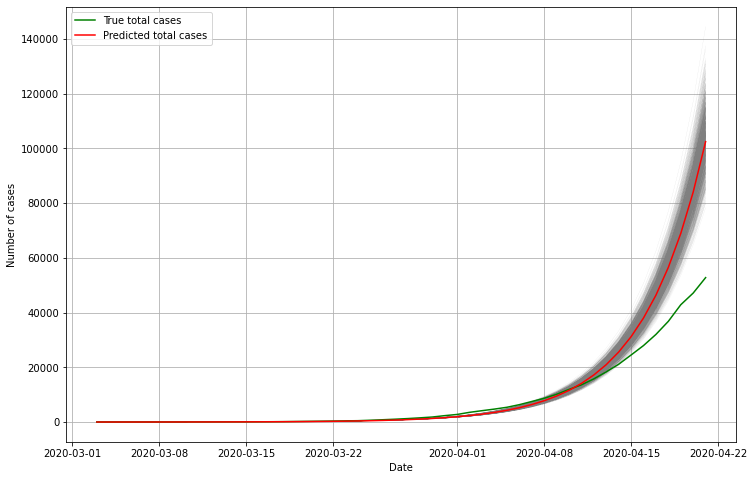

In [11]:
#sampling
weights = np.random.multivariate_normal(mu_n, sigma_n, NUMBER_OF_SAMPLES)

#plotting
plt.figure(figsize=FIGURE_SIZE)
plt.grid(True)
for n in range(NUMBER_OF_SAMPLES):
    y = np.exp(train_data[DAY_COUNTER].values * weights[n][1] + weights[n][0])
    plt.plot(train_data[DATE], y, linewidth=0.05, color = 'gray')
    
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.plot(train_data[DATE], train_data[TOTAL_CASES], color='green', label='True total cases')
plt.plot(train_data[DATE], np.exp(prediction), color='red', label='Predicted total cases')
plt.legend()

In [12]:
def plot_histogram_from_samples_exponent(weights, date):
    date_counter = (date - RUSSIA_START_DATE).days
    predictions = np.exp(weights.dot(np.array([1, date_counter]).T))
    plt.figure(figsize=FIGURE_SIZE)
    plt.grid(True)
    plt.hist(predictions, bins = 15)
    print(f'On the {date} there would be {round(np.mean(predictions))} cases')
    plt.xlabel('Number of cases')
    plt.ylabel('Sample count')
    plt.title(f'Histogram of samples on {date}');

On the 2020-05-01 00:00:00 there would be 757453 cases


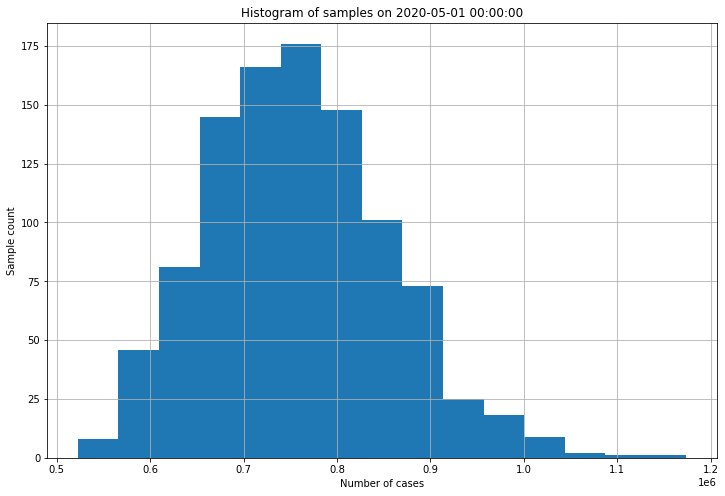

In [13]:
#first of may
plot_histogram_from_samples_exponent(weights, FIRST_MAY)

On the 2020-06-01 00:00:00 there would be 362721111 cases


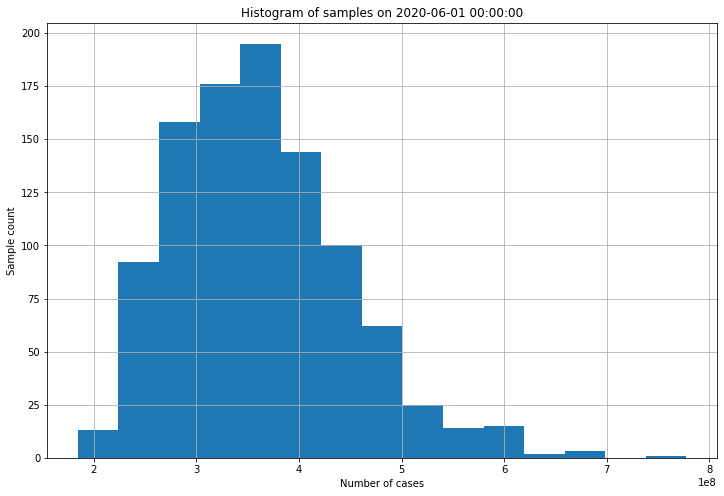

In [14]:
#first of june
plot_histogram_from_samples_exponent(weights, FIRST_JUNE)

On the 2020-09-01 00:00:00 there would be 34897216997765552 cases


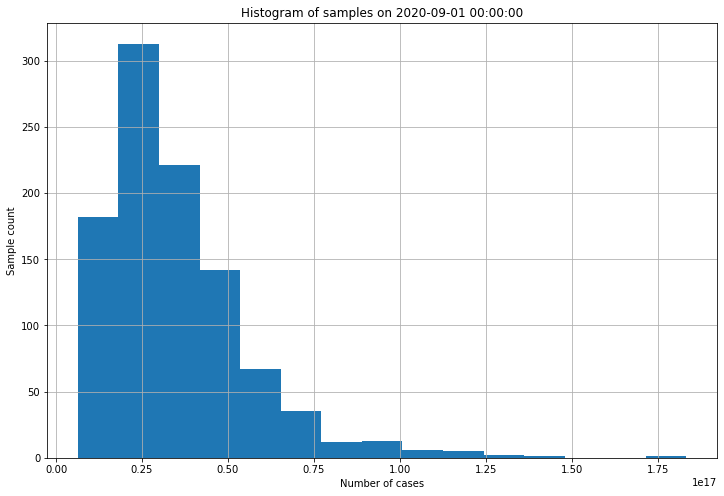

In [15]:
#first of september
plot_histogram_from_samples_exponent(weights, FIRST_SEPTEMBER)

Предложите способ обучать параметры сигмоидальной функции при помощи линейной регрессии.

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$
\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-\frac{t^2}{2}}dt
$$

**a.** Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

В качестве функции под экспонентой воспользуемся полиномом второй степени, а так же введем константу под знак интеграла:

$$
y(x) = \int_{-\infty}^x e^{w_2t^2 + w_1t + w_0}dt
$$

Перейдем к дискретному случаю:
$$
y_i - y_{i-1} = e^{w_2t^2 + w_1t + w_0}
$$

**b.** Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.


In [16]:
_, train_data = get_data()

estimator = LinearRegression()
X_train = np.column_stack([np.ones_like(train_data[DAY_COUNTER]), train_data[DAY_COUNTER], train_data[DAY_COUNTER] ** 2])
estimator.fit(X_train, np.log(train_data[NEW_CASES].values))
prediction = estimator.predict(X_train)

In [17]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([x])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [18]:
sigma_n = 100 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
mu_n = np.array([0, 0, 0])
x = X_train
y = np.log(train_data[NEW_CASES]).values
sigma_noise = np.std(np.log(train_data[NEW_CASES]) - prediction)

for i in range(0, len(train_data[TOTAL_CASES])):
    mu_n, sigma_n = bayesian_update(mu_n, sigma_n, x[i], y[i], sigma_noise)
    
print(f'sigma:\n {sigma_n}')
print(f'mu: {mu_n}')

sigma:
 [[ 3.97858000e-02 -3.21446447e-03  5.41155378e-05]
 [-3.21446447e-03  3.54467031e-04 -6.76539758e-06]
 [ 5.41155378e-05 -6.76539758e-06  1.38075588e-07]]
mu: [-0.39642376  0.27560911 -0.00182956]


**c.** Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

Text(0, 0.5, 'Number of cases')

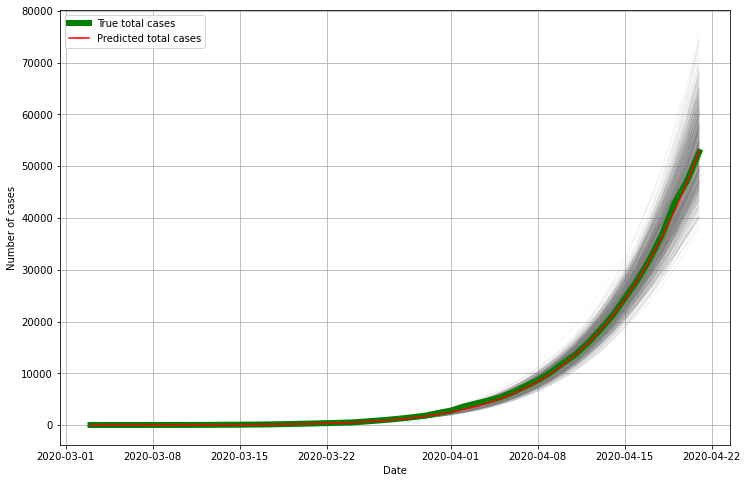

In [19]:
#sampling
weights = np.random.multivariate_normal(mu_n, sigma_n, NUMBER_OF_SAMPLES)

#plotting
plt.figure(figsize=FIGURE_SIZE)

for n in range(NUMBER_OF_SAMPLES):
    y = np.exp(train_data[DAY_COUNTER].values ** 2 * weights[n][2] + train_data[DAY_COUNTER].values * weights[n][1] + weights[n][0]).cumsum()
    plt.plot(train_data[DATE], y, linewidth=0.05, color = 'gray')

plt.plot(train_data[DATE], train_data[TOTAL_CASES], linewidth=6, color='green', label='True total cases')
plt.plot(train_data[DATE], np.exp(prediction).cumsum(), color='red', label='Predicted total cases')
plt.legend()
plt.grid(True)
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)

In [20]:
def plot_histogram_from_samples_sigmoid(weights, date):
    date_counter = (date - RUSSIA_START_DATE).days
    x = np.arange(date_counter + 1)
    days = np.column_stack([np.ones(date_counter + 1), x, x ** 2])
    predictions = np.exp(weights.dot(days.T)).cumsum(1)[:, date_counter]
    plt.figure(figsize=FIGURE_SIZE)
    plt.grid(True)
    plt.hist(predictions, bins = 15)
    print(f'positive scenario for {date} {round(np.quantile(predictions, 0.1))}')
    print(f'average scenario for {date} {round(np.quantile(predictions, 0.5))}')
    print(f'negative scenario for {date} {round(np.quantile(predictions, 0.9))}')
    plt.xlabel('Number of cases')
    plt.ylabel('Sample count')
    plt.title(f'Histogram of samples on {date}');

positive scenario for 2020-05-01 00:00:00 112098
average scenario for 2020-05-01 00:00:00 151298
negative scenario for 2020-05-01 00:00:00 213359


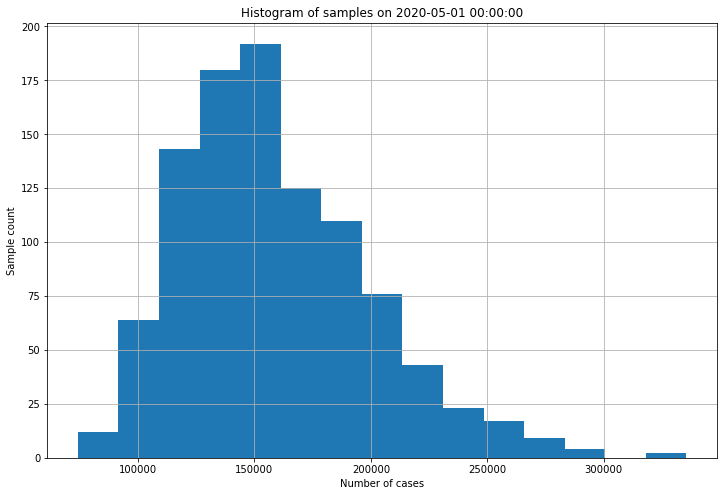

In [21]:
#first may
plot_histogram_from_samples_sigmoid(weights, FIRST_MAY)

positive scenario for 2020-06-01 00:00:00 307478
average scenario for 2020-06-01 00:00:00 735760
negative scenario for 2020-06-01 00:00:00 2476988


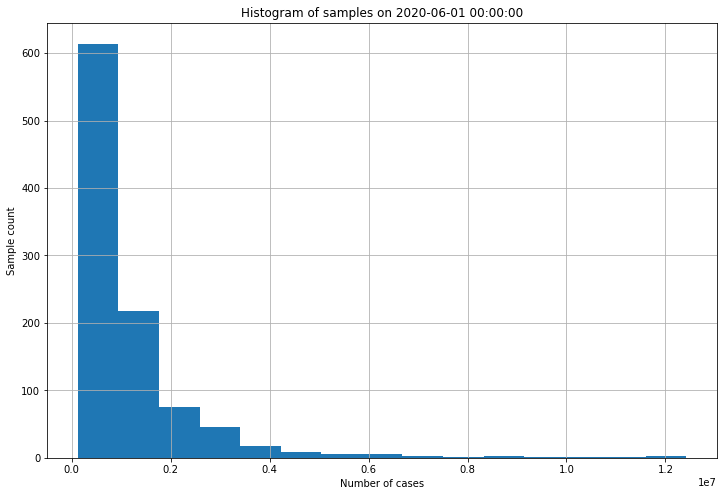

In [22]:
#first june
plot_histogram_from_samples_sigmoid(weights, FIRST_JUNE)

positive scenario for 2020-09-01 00:00:00 321907
average scenario for 2020-09-01 00:00:00 903338
negative scenario for 2020-09-01 00:00:00 5728138


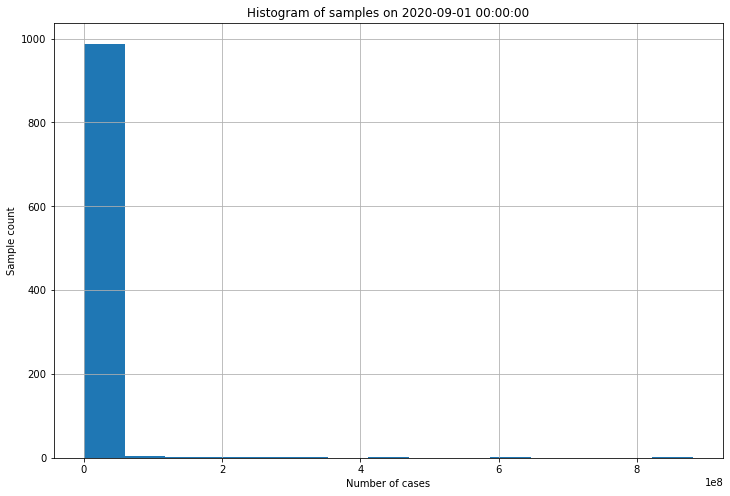

In [23]:
#first september
plot_histogram_from_samples_sigmoid(weights, FIRST_SEPTEMBER)

5. [Эта часть задания не оценивается, здесь нет правильных и неправильных ответов, но буду рад узнать, что вы думаете]
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?


1. Мир не всегда таков, каким он кажется на первый взгляд (хотя, я догадывался об этом и раньше).
2. Когда есть какие-то априорные знания о природе данных, решение может быть гораздо проще. 
3. Мне кажется, карантин ввели из-за паники. Вполне возможно, что кто-то увидел рост, похожий на экспоненту и на основании этого сделал вывод о необходимости карантина. С другой стороны, область здравоохранения довольна консервативна, поэтому, когда появляется *непонятная* болезнь - локдаун, возможно, лучший вариант. Я бы не хотел быть тем человеком, кто принимает такие решение.